In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset import KSponSpeechDataset, DataCollate
from torch.utils.data import DataLoader
from jamo import n_symbols, text_to_tokens, tokens_to_text

### Dataset

In [3]:
dataset = KSponSpeechDataset(root_dir='/data/KsponSpeech')
train_loader = DataLoader(dataset, num_workers=8, shuffle=True, batch_size=64, collate_fn=DataCollate())
print(train_loader)

622545


### Model

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, min_width=4):
        super().__init__()
        self.in_layer = nn.Sequential(nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
                                      nn.BatchNorm1d(hidden_channels),
                                      nn.ReLU())
        self.lstm1 = nn.LSTM(hidden_channels, hidden_channels//2, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_channels*2, hidden_channels//2, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(hidden_channels*2, hidden_channels//2, batch_first=True, bidirectional=True)
        self.out_layer = nn.Linear(hidden_channels, out_channels)
        self.hidden_channels = hidden_channels
        self.min_width = min_width
        
    def forward(self, x):
        b, t, _ = x.size()
        
        pad_length = ((t - 1) // self.min_width + 1) * self.min_width - t
        x = F.pad(x, (0, 0, 0, pad_length))
        
        # x : (batch, time, channel)
        y = self.in_layer(x.transpose(1, 2)).transpose(1, 2)
        
        # (batch, time, channel)
        y, _ = self.lstm1(y)
        # (batch, time/2, channel)
        y = y.reshape(b, y.size(1)//2, self.hidden_channels*2)
        
        # (batch, time/2, channel)
        y, _ = self.lstm2(y)
        # (batch, time/4, channel)
        y = y.reshape(b, y.size(1)//2, self.hidden_channels*2)
        
        # (batch, time/4, channel)
        y, _ = self.lstm3(y)
        y = self.out_layer(y)
        
        return y
        

In [5]:
import numpy as np

class Decoder(nn.Module):
    def __init__(self, n_symbols, embedding_channels, hidden_channels, encoded_channels):
        super().__init__()
        self.embedding = nn.Embedding(n_symbols, embedding_channels)
        self.in_layer = nn.Sequential(nn.Linear(embedding_channels, hidden_channels),
                                      nn.ReLU(),
                                      nn.Linear(hidden_channels, hidden_channels))
        self.lstm1 = nn.LSTMCell(hidden_channels, hidden_channels)
        self.lstm2 = nn.LSTMCell(hidden_channels+encoded_channels, hidden_channels)
        self.out_layer = nn.Linear(hidden_channels, n_symbols)
        self.W = nn.Parameter(torch.randn(1, hidden_channels, encoded_channels))
        self.encoded_channels = encoded_channels
    
    def _get_attention_context(self, s, h):
        # s : (batch, hidden)
        # h : (batch, length, encoded)
        
        # (batch, 1, length) = (batch, 1, hidden) @ (1, hidden, encoded) @ (batch, encoded, length)
        score = s.unsqueeze(1) @ self.W @ h.transpose(1, 2)
        score = score / np.sqrt(self.encoded_channels)
        # (batch, 1, length)
        weight = score.softmax(dim=2)
        # (batch, 1, encoded)
        context = weight @ h
        
        # (batch, encoded)
        return context[:, 0], weight[:, 0]
        
        
    def forward(self, x, h):
        # x : (batch, time, channel)
        # h : (batch, length, channel)
        
        x = self.embedding(x)
        x = self.in_layer(x)
        state1 = None # (hidden, cell)
        state2 = None # (hidden, cell)
        outputs = []
        alignments = []
        for t in range(x.size(1)):
            # (hidden, cell)
            state1 = self.lstm1(x[:, t], state1)
            # (batch, encoded)
            context, weight = self._get_attention_context(state1[0], h)
            alignments.append(weight)
            # (hidden, cell)
            state2 = self.lstm2(torch.cat([state1[0], context], dim=1), state2)
            outputs.append(state2[0])
            
        # (batch, time, channel)
        outputs = torch.stack(outputs, dim=1)
        # (batch, length, time)
        alignments = torch.stack(alignments, dim=2)
        x = self.out_layer(outputs)
        
        return x, alignments
    
    def inference(self, h):
        # h : (1, length, channel)
        tokens = torch.zeros(size=(1, 1)).long().to(h.device)
        
        state1 = None
        state2 = None
        alignments = []
        logprob = 0
        for _ in range(1000):
            x = tokens[:, -1]
            x = self.embedding(x)
            x = self.in_layer(x)
            state1 = self.lstm1(x, state1)
            context, weight = self._get_attention_context(state1[0], h)
            alignments.append(weight)
            state2 = self.lstm2(torch.cat([state1[0], context], dim=1), state2)
            logit = self.out_layer(state2[0])
            token = torch.distributions.categorical.Categorical(logits=logit).sample().to(h.device)
            logprob += logit.log_softmax(dim=1)[0, token[0].item()].item()
            tokens = torch.cat([tokens, token.unsqueeze(0)], dim=1)
            if token[0].item() == 0:
                break
            
        alignments = torch.stack(alignments, dim=2)
            
        return tokens, alignments, logprob
    
    def beam_search(self, h, beam_size=10):
        tokens = torch.zeros(size=(1, 1)).long().to(h.device)
        
        # (tokens, state1, state2, alignments, log_prob, end)
        beam_list = [(tokens, None, None, [], 0, False)]
        beam_lists = []
        for _ in range(1000):
            new_beam_list = []
            beam_lists.append(beam_list)
            for beam in beam_list:
                tokens, state1, state2, alignments, log_prob, end = beam
                if end:
                    new_beam_list.append(beam)
                    continue
                    
                x = tokens[:, -1]
                x = self.embedding(x)
                x = self.in_layer(x)
                state1 = self.lstm1(x, state1)
                context, weight = self._get_attention_context(state1[0], h)
                alignments.append(weight)
                state2 = self.lstm2(torch.cat([state1[0], context], dim=1), state2)
                # (1, n_symbols)
                logits = self.out_layer(state2[0])
                # (1, n_symbols)
                new_log_probs = logits.log_softmax(dim=1)
                # (1, beam_size), (1, beam_size)
                new_log_probs, indexes = new_log_probs.topk(beam_size, dim=1)
                for i in range(new_log_probs.size(1)):
                    new_tokens = torch.cat([tokens, indexes[:, i:i+1]], dim=1)
                    new_log_prob = log_prob + new_log_probs[0, i].item()
                    if indexes[0, i].item() == 0:
                        end = True
                    new_beam_list.append((new_tokens, state1, state2, alignments, new_log_prob, end))
            
            new_beam_list = sorted(new_beam_list, key=lambda x:x[4] / x[0].size(1), reverse=True)
            beam_list = new_beam_list[:beam_size]
            
            all_end = True
            for beam in beam_list:
                all_end = all_end and beam[5]
            if all_end:
                break
        
        return beam_list, beam_lists
                    

In [6]:
class LAS(nn.Module):
    def __init__(self, mel_channels, 
                       encoder_hidden_channels,
                       encoder_output_channels,
                       n_symbols,
                       embedding_channels,
                       decoder_hidden_channels):
                      
        super().__init__()
        self.encoder = Encoder(mel_channels, encoder_hidden_channels, encoder_output_channels)
        self.decoder = Decoder(n_symbols, embedding_channels, decoder_hidden_channels, encoder_output_channels)
        
    def forward(self, x, y):
        # x : (batch, time, mel_channels)
        # y : (batch, length)
        
        h = self.encoder(x)
        out, alignments = self.decoder(y, h)
        
        return out, alignments
    
    def inference(self, x):
        # x : (batch, time, mel_channels)
        h = self.encoder(x)
        out, alignments, logprob = self.decoder.inference(h)
        
        return out, alignments, logprob
    
    def beam_search(self, x, beam_size=10):
        # x : (batch, time, mel_channels)
        h = self.encoder(x)
        beam_list, beam_lists = self.decoder.beam_search(h, beam_size=beam_size)
        
        return beam_list, beam_lists
        

### Logger

In [7]:
from utils import sizeof_fmt, Logger

In [8]:
!mkdir save
save_dir = 'save/las_lstm_kspon'
logger = Logger(save_dir=save_dir, new=False)
print(logger)

mkdir: cannot create directory ‘save’: File exists


In [9]:
!ls $save_dir

save_0	    save_15000	save_25000  save_30711
save_10000  save_20000	save_30000  save_5000


### Init Model

In [10]:
model = LAS(mel_channels=80, 
           encoder_hidden_channels=512,
           encoder_output_channels=512,
           n_symbols=n_symbols,
           embedding_channels=512,
           decoder_hidden_channels=512)

model = model.cuda()
step = 30711

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
    print('loaded', step)

Model size 51.8MiB
loaded : 30711
loaded 30711


In [11]:
def to_cuda(batch):
    batch['audio'] = batch['audio'].cuda()
    batch['audio_lengths'] = batch['audio_lengths'].cuda()
    batch['text'] = F.pad(batch['text'].cuda(), (1, 1))
    batch['text_lengths'] = batch['text_lengths'].cuda() + 2
    
    return batch

### Train

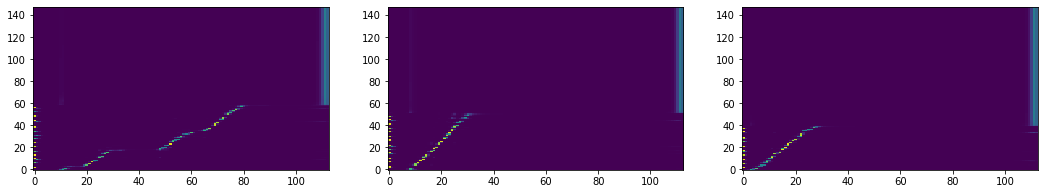

ground truth :  오 대박이다. 나도 스위스 간 적 있거든?                                                                                         
beam search
 오 대박이다. 나도 스에스 간 적이 있거든?  -5.331748947733786
 오 대박이다. 나도 스에스 간적이 있거든?  -5.273309580356198
 오 대박이다. 나도 스위스 간적이 있거든?  -5.474907666925191
 오 대박이다. 나도 스에스 간 적이 있거든.  -5.698828134452697
 오 대박이다. 나도 스에스 간적이 있거든.  -5.645561967583689


In [18]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

stop = True
while True:
    for batch in train_loader:
        batch = to_cuda(batch)
        model.train()
        model.zero_grad()
        logits, alignments = model(batch['audio'], batch['text'])
        loss = nn.CrossEntropyLoss()(logits[:, :-1].transpose(1, 2), batch['text'][:, 1:])
        loss.backward()
        optimizer.step()
        
        print(step, loss.item())
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
            
        if step % 100 == 0:
            display.clear_output()
            
            _alignment = alignments.data.cpu().numpy()
            plt.figure(figsize=[18, 3])
            plt.title('Attention Alignments')
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_alignment[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            text = tokens_to_text(batch['text'][0].data.cpu().numpy())
            print('ground truth :', text)
            
            print('beam search')
            model.eval()
            with torch.no_grad():
                beam_list, beam_lists = model.beam_search(batch['audio'][0:1], beam_size=5)
                for beam in beam_list:
                    text = tokens_to_text(beam[0][0].data.cpu().numpy())
                    score = beam[4]
                    print(text, score)
                    
            if stop:
                break
                
        step += 1
        
    if stop:
        break

In [28]:
logger.save(step, model, optimizer)

saved save/las_lstm_kspon/save_30711
